In [1]:
import iris
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
%matplotlib notebook


In [2]:
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)


Download example data:

In [4]:
import urllib
file_path='http://gws-access.ceda.ac.uk/public/acpc/mheiken/Tracking/Small_Example/Example_OLR/Example_input.nc'
data_dir='Data'
os.makedirs(data_dir,exist_ok=True)
data_file=os.path.join(data_dir,'data.nc')
request=urllib.request.urlretrieve(file_path,data_file)

Load Data from downloaded file:

In [5]:
OLR=iris.load_cube(data_file,'OLR')


In [6]:
#time and space constraint:
time_range=[datetime.datetime(2013,6,19,21,30,0), datetime.datetime(2013,6,19,23,30,0)]
x_range=np.array([900e3,1500e3])
y_range=np.array([850e3,1150e3])

#iris constraints:
constraint_time=iris.Constraint(time= lambda cell: time_range[0] < cell < time_range[1])
constraint_x = iris.Constraint(projection_x_coordinate = lambda cell: x_range[0] < cell < x_range[1])
constraint_y = iris.Constraint(projection_y_coordinate = lambda cell: y_range[0] < cell < y_range[1])
constraint_space= constraint_x & constraint_y
constraint=constraint_time & constraint_space
OLR=OLR.extract(constraint)

In [7]:
savedir='Save_OLR_model'
os.makedirs(savedir,exist_ok=True)


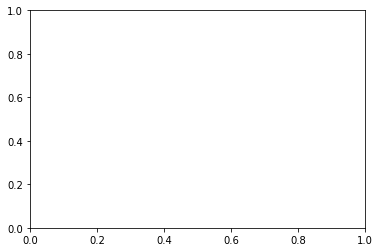

In [8]:
import tobac
%config tobac.log_level="DEBUG"
from tobac import get_spacings,feature_detection_multithreshold,segmentation_2D,linking_trackpy


In [9]:
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_num']=4
parameters_features['target']='minimum'
parameters_features['threshold']=[250,225,200,175,150]




In [10]:
dxy,dt=get_spacings(OLR)
Features=feature_detection_multithreshold(OLR,dxy,**parameters_features)
Features.to_hdf(os.path.join(savedir,'Features.h5'),'table')

In [11]:
#setup for saving masks:                        
zlib=True
#zlib=False
# Set to compression level
complevel=4
packing=None
chunksizes=None
packing={'dtype': np.int32, 'scale_factor':1, 'add_offset':1}

In [12]:
parameters_segmentation={}
parameters_segmentation['target']='minimum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=250


In [13]:
#perform 2D segmentation based on total condenate
Mask_OLR,Features_OLR=segmentation_2D(Features,OLR,dxy,**parameters_segmentation)
chunksizes=list(Mask_OLR.shape)
chunksizes[0]=1
logging.debug('segmentation OLR performed, start saving results to files')
iris.save([Mask_OLR],os.path.join(savedir,'Mask_Segmentation_OLR.nc'),zlib=zlib,complevel=complevel,packing=packing,chunksizes=chunksizes)                
Features_OLR.to_hdf(os.path.join(savedir,'Features_OLR.h5'),'table')
logging.debug('segmentation OLR performed and saved')


2018-11-02 16:00:24,359 | INFO : Start wateshedding 2D


In [14]:
parameters_linking={}
parameters_linking['v_max']=20
parameters_linking['stubs']=2
parameters_linking['order']=1
parameters_linking['extrapolate']=1
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'


In [15]:
Track=linking_trackpy(Features,OLR,dt=dt,dxy=dxy,**parameters_linking)
#save trajectories:
Track.to_hdf(os.path.join(savedir,'Track.h5'),'table')


Frame 22: 35 trajectories present.


Plot some results for a specific timestep:
    

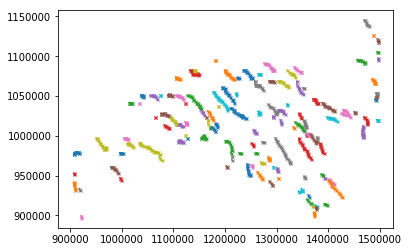

In [16]:
fig1,ax1=plt.subplots()
for cell in Track['cell'].dropna().unique():
    Track_i=Track[Track['cell']==cell]
    ax1.plot(Track_i['projection_x_coordinate'],Track_i['projection_y_coordinate'],'-x',markersize=3)

In [17]:
plot_dir="Plots_OLR_Satellite"
os.makedirs(plot_dir,exist_ok=True)


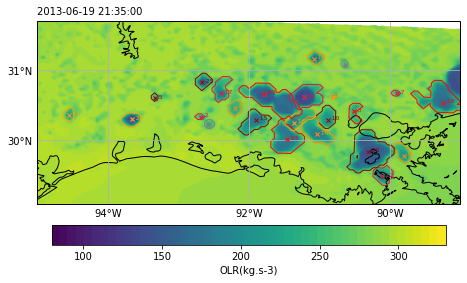

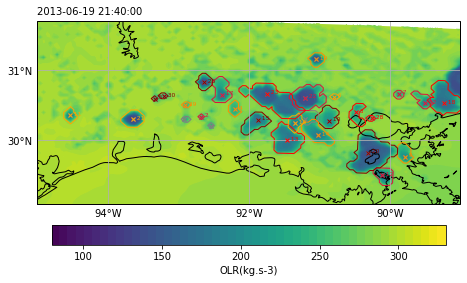

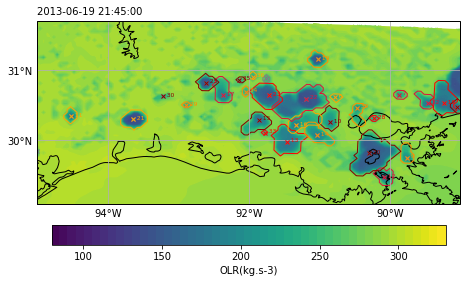

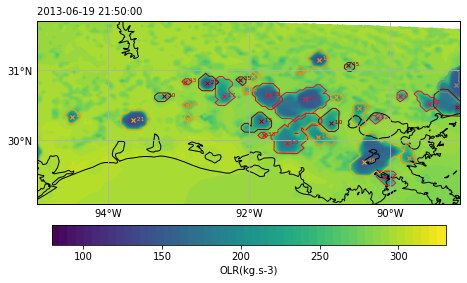

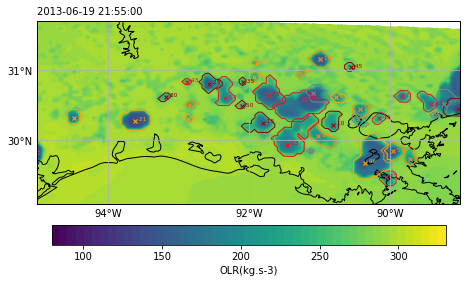

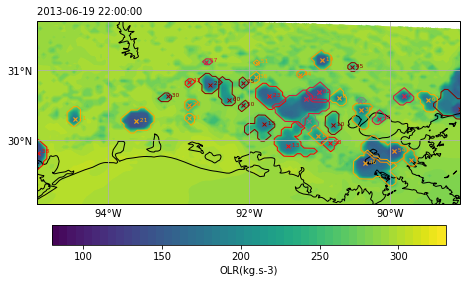

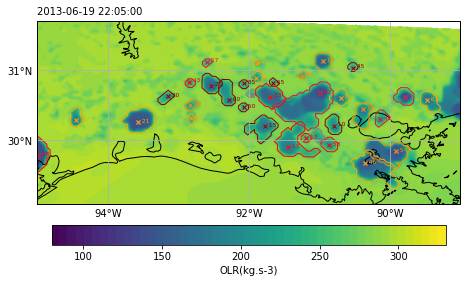

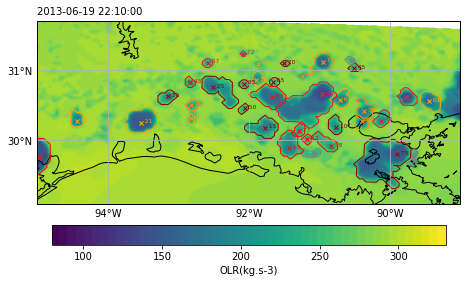

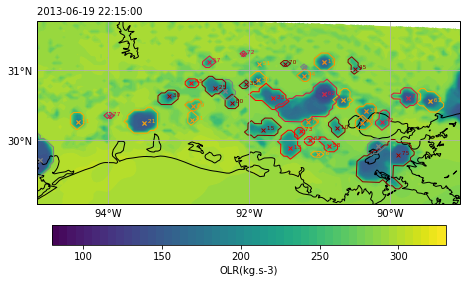

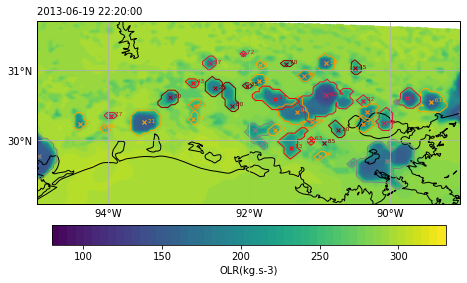

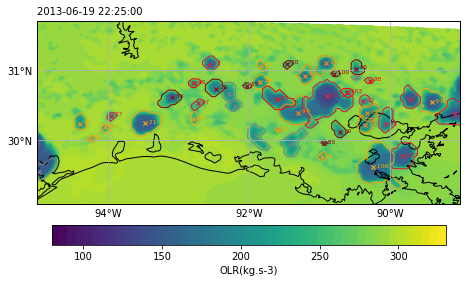

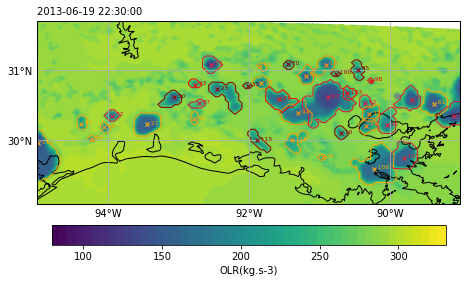

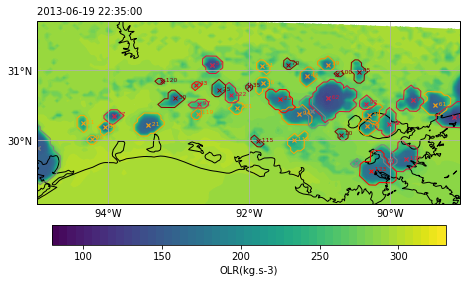

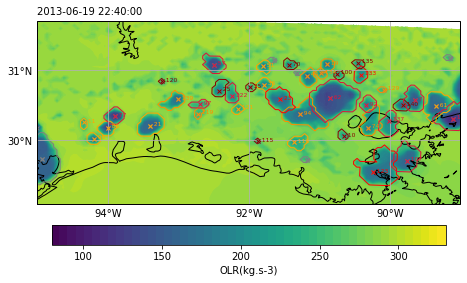

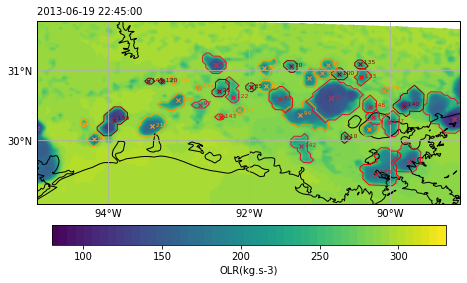

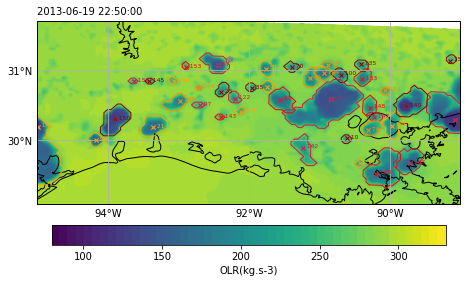

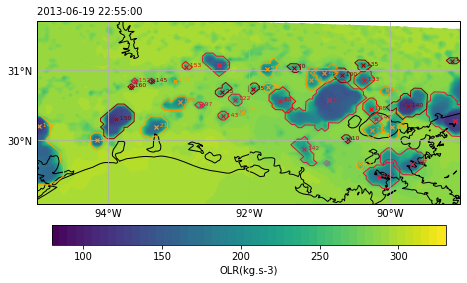

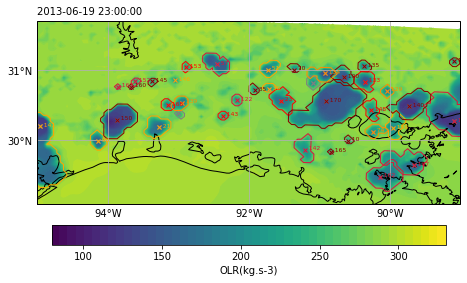

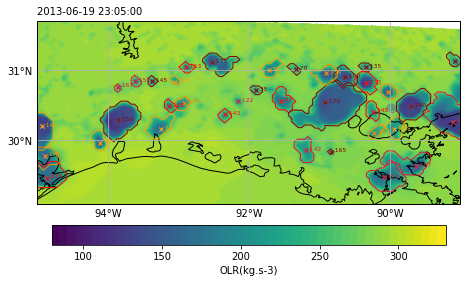

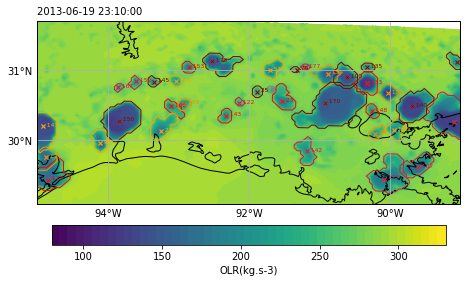

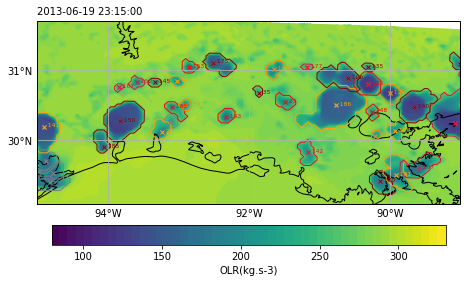

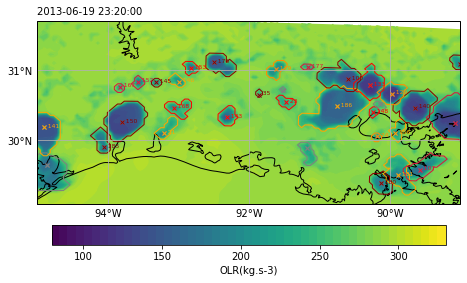

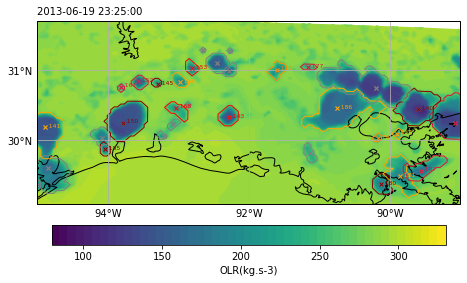

In [18]:
from tobac import plot_tracks_mask_field
from iris import Constraint
import cartopy.crs as ccrs

axis_extent=[-95,-89,29.1,31.7]        
figsize=(20/2.64,20/2.54)
time=OLR.coord('time')
for time_i in time.points:
    datetime_i=time.units.num2date(time_i)
    constraint_time = Constraint(time=datetime_i)
    OLR_i=OLR.extract(constraint_time)
    mask_i=Mask_OLR.extract(constraint_time)
    track_i=Track[Track['time']==datetime_i]
    features_i=Features[Features['time']==datetime_i]
    fig1,ax1=plt.subplots(ncols=1, nrows=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    plot_tracks_mask_field(track_i,field=OLR_i,mask=mask_i,features=features_i,
                            axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                            vmin=80,vmax=330,axes=ax1,
                            plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)
        


In [19]:
plt.show()